In [1]:
import os
os.chdir("/content/")

!rm -rf /content/ee239as-project
!git clone https://github.com/binhanle/ee239as-project

Cloning into 'ee239as-project'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 158 (delta 91), reused 103 (delta 40), pack-reused 0
Receiving objects: 100% (158/158), 28.49 KiB | 3.17 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [2]:
os.chdir("/content/ee239as-project")
!git pull

!pip install -r requirements.txt

Already up to date.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Prepare Atari environment and DQN agent

In [5]:
import torch
from nn_models import DQN, DQN_alternate
from memory import ReplayMemory
from dqnagent import DQNAgent
from ddqnagent import DDQNAgent
from checkpoint import save_checkpoint, load_checkpoint
from atari_wrappers import make_atari, wrap_deepmind, clip_reward
import numpy as np
import gym
import os

# set environment here
# ATARI_GAME = "BreakoutNoFrameskip-v4"
# ATARI_GAME = "PongNoFrameskip-v4"
# ATARI_GAME = "GopherNoFrameskip-v4"
# ATARI_GAME = "VideoPinballNoFrameskip-v4"
ATARI_GAME = "RoadRunnerNoFrameskip-v4"
# ATARI_GAME = "PongNoFrameskip-v4"
# ATARI_GAME = "AsterixNoFrameskip-v4"
print("Using atari game:", ATARI_GAME)

env = make_atari(ATARI_GAME)
env = wrap_deepmind(env, clip_rewards=False)

N_ACTIONS = env.action_space.n
print("Action space is:", env.action_space)

STATE_SHAPE = env.observation_space.shape
print("Observation space is:", STATE_SHAPE)

"""
Define agent training parameters (memory buffer size, target update interval, gamma, learning rate, optimizer, etc.)
Create environment using gym
Create a DQN/DDQN agent

Define other training parameters (start/end epsilon, explore phase length, etc.)
for each episode:
    reset environment
    while(episode not done):
        Update epsilon (if not at epsilon_min or in exploration phase)
        Take action according to epsilon-greedy
        Add (current_state, action, reward, next_state, terminal_indicator) to memory buffer
        if (num_steps % online_update_interval == 0):
            Sample memory buffer
            Calculate value function using network
            Update online network
        if (num_steps % target_update_interval == 0):
            Copy parameters from online network
        


Define testing parameters (epsilon)
for each episode:
    reset environment
    while(episode not done):
        Take action according to epsilon-greedy
        Update reward
"""
# set training parameters here

MEMORY_SIZE = 10000 # maximum size of memory buffer, increase to as large as possible (paper used 1 million)
LR = 0.0000625 # learning rate (paper used 0.00025)
GAMMA = 0.99
BATCH_SIZE = 32 # batch size for parameter updates (paper used 32)
UPDATE_ONLINE_INTERVAL = 4 # number of steps in bewteen parameter updates to online net
UPDATE_TARGET_INTERVAL_DQN = 10000 # how frequently parameters are copied from online net to target net 
UPDATE_TARGET_INTERVAL_DDQN = 10000 #(paper untuned DQN/DDQN used 10k, paper tuned DDQN used 30k)
use_DQN = False

CKPT_FILENAME = ATARI_GAME + ".ckpt"
CKPT_ENABLED = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dqn_online = DQN(N_ACTIONS, STATE_SHAPE)
dqn_target = DQN(N_ACTIONS, STATE_SHAPE)
#dqn_online = DQN_alternate(N_ACTIONS, STATE_SHAPE)
#dqn_target = DQN_alternate(N_ACTIONS, STATE_SHAPE)

dqn_online.to(device)
dqn_target.to(device)
#optimizer = torch.optim.RMSprop(dqn_online.parameters(), lr=LR, momentum=0.95, eps=0.01) # paper used (rms prop)
optimizer = torch.optim.Adam(dqn_online.parameters(), lr=LR)
"""if CKPT_ENABLED and os.path.exists(CKPT_FILENAME):
    progress = load_checkpoint(dqn_online, dqn_target, optimizer, CKPT_FILENAME)
else:
    progress = []
"""

dqn_target.eval()
mem_buffer = ReplayMemory(MEMORY_SIZE, STATE_SHAPE)

loss_fn = torch.nn.SmoothL1Loss() # huber loss function
if(use_DQN):
  agent = DQNAgent(device, mem_buffer, dqn_online, dqn_target, optimizer, loss_fn, GAMMA, BATCH_SIZE, UPDATE_ONLINE_INTERVAL, UPDATE_TARGET_INTERVAL_DQN)
  print("here1")
else:
  print("here2")
  agent = DDQNAgent(device, mem_buffer, dqn_online, dqn_target, optimizer, loss_fn, GAMMA, BATCH_SIZE, UPDATE_ONLINE_INTERVAL, UPDATE_TARGET_INTERVAL_DDQN)


Using atari game: RoadRunnerNoFrameskip-v4
Action space is: Discrete(18)
Observation space is: (4, 84, 84)
here2


### List of Atari Environments

In [0]:
from gym import envs
all_envs = envs.registry.all()
env_ids = [env_spec.id for env_spec in all_envs]
print(env_ids)

# Begin training

In [0]:
progress = []
# adjust these hyperparameters as necessary
num_episodes = 30000 # number of episodes to train for
explore_phase_length = 50000 # number of steps without any exploitation (paper used 50k)
epsilon = 1.0 # initial epsilon value (paper used 1.0)
epsilon_decrement_steps = 1000000 # how many steps to decrement epsilon to min value (paper used 1 million)
intermediate_epsilon = 0.1 # can be used to decay epsilon in two phases as recommended by openai (set equal to min_epsilon to disable)
if (use_DQN):
  min_epsilon = 0.1 # smallest possible value of epsilon (paper used 0.1 for dqn, 0.01 for ddqn)
else:
  min_epsilon = 0.01

print(min_epsilon)
epsilon_dec = (epsilon - intermediate_epsilon) / epsilon_decrement_steps
final_epsilon_decay = (intermediate_epsilon - min_epsilon) / epsilon_decrement_steps

total_steps = 0
max_score = 0.0
for i_episode in range(num_episodes):
  # print("Running episode:", i_episode)
  score = 0.0
  agent_score = 0.0
  done = False
  time_step = 0
  model_updates = 0
  mean_loss = 0

  cur_state = env.reset()

  while not done:
    
    
    # linearly anneal epsilon
    if total_steps > explore_phase_length:
      epsilon = max(epsilon - epsilon_dec, min_epsilon)
      if total_steps >= explore_phase_length + epsilon_decrement_steps:
        epsilon_dec = final_epsilon_decay
    
    if total_steps > explore_phase_length and np.random.random() > epsilon:
        action = agent.select_action(cur_state) # exploit
    else:
        action = env.action_space.sample() # explore

    next_state, reward, done, info = env.step(action)
    agent_reward = clip_reward(reward)
    agent.add_memory(cur_state, action, agent_reward, next_state, done)

    score += reward
    agent_score += agent_reward
    
    loss = agent.optimize_model()
    if loss is not None:
        model_updates += 1
        delta = loss - mean_loss
        mean_loss += delta / model_updates

    cur_state = next_state
    
    time_step += 1
    total_steps += 1
    # if time_step % 100 == 0:
    #   print("Completed iteration", time_step)

  print("Episode {} score: {}, agent score: {}, total steps taken: {}, epsilon: {}".format(i_episode, score, agent_score, total_steps, epsilon))
  progress.append((time_step, total_steps, score, agent_score, mean_loss))
  # print("Progress is", progress)
  if CKPT_ENABLED and score > max_score:
    max_score = score
    save_checkpoint(progress, dqn_online, dqn_target, optimizer, CKPT_FILENAME)

Streaming output truncated to the last 5000 lines.
Episode 15737 score: 11600.0, agent score: 44.0, total steps taken: 2634594, epsilon: 0.01
Episode 15738 score: 12500.0, agent score: 55.0, total steps taken: 2635116, epsilon: 0.01
Episode 15739 score: 3200.0, agent score: 14.0, total steps taken: 2635297, epsilon: 0.01
Episode 15740 score: 3800.0, agent score: 15.0, total steps taken: 2635417, epsilon: 0.01
Episode 15741 score: 4300.0, agent score: 19.0, total steps taken: 2635796, epsilon: 0.01
Episode 15742 score: 2700.0, agent score: 12.0, total steps taken: 2636011, epsilon: 0.01
Episode 15743 score: 2500.0, agent score: 12.0, total steps taken: 2636216, epsilon: 0.01
Episode 15744 score: 5600.0, agent score: 23.0, total steps taken: 2636442, epsilon: 0.01
Episode 15745 score: 7100.0, agent score: 33.0, total steps taken: 2636683, epsilon: 0.01
Episode 15746 score: 1000.0, agent score: 5.0, total steps taken: 2636805, epsilon: 0.01
Episode 15747 score: 17100.0, agent score: 71.0,

# Visualize results

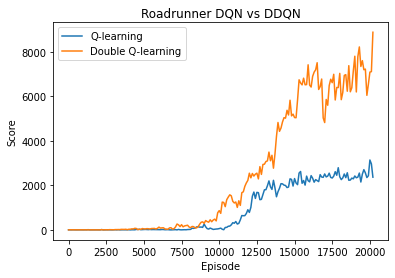

In [12]:
import matplotlib.pyplot as plt
#save_checkpoint(progress, dqn_online, dqn_target, optimizer, CKPT_FILENAME)
score_hist = []
score_hist_dqn = []
bin_size = 100
for start in range(0, len(progress), bin_size):
  score_hist.append(np.mean(np.array(progress[start:start+bin_size])[:, 2]))
  score_hist_dqn.append(np.mean(np.array(progress_dqn[start:start+bin_size])[:, 2]))
plt.plot(range(0, len(progress), bin_size), score_hist_dqn, label='Q-learning')
plt.plot(range(0, len(progress), bin_size), score_hist, label='Double Q-learning')
plt.legend()
plt.title("Roadrunner DQN vs DDQN")
plt.ylabel("Score")
plt.xlabel("Episode")
plt.show()

### Testing

In [0]:
# adjust these hyperparameters as necessary
num_episodes = 100 # number of episodes to test for
epsilon_test = 0.001 # (0.001 used in paper. Untuned was 0.05)

total_steps = 0
max_score = 0.0
progress_test = []
for i_episode in range(num_episodes):
  score = 0.0
  agent_score = 0.0
  done = False
  time_step = 0

  cur_state = env.reset()

  while not done:
    if np.random.random() > epsilon_test:
        action = agent.select_action(cur_state) # exploit
    else:
        action = env.action_space.sample() # explore

    next_state, reward, done, info = env.step(action)
    agent_reward = clip_reward(reward)

    score += reward
    agent_score += agent_reward

    cur_state = next_state
    
    time_step += 1
    total_steps += 1
    # if time_step % 100 == 0:
    #   print("Completed iteration", time_step)

  print("Episode {} score: {}, agent score: {}, total steps taken: {}, epsilon: {}".format(i_episode, score, agent_score, total_steps, epsilon_test))
  progress_test.append((i_episode, time_step, total_steps, score, agent_score))
  # print("Progress is", progress)
  if CKPT_ENABLED and score > max_score:
    max_score = score
    save_checkpoint(progress, dqn_online, dqn_target, optimizer, CKPT_FILENAME)

In [0]:
import matplotlib.pyplot as plt

score_hist_test = []
for start in range(len(progress_test)):
  score_hist_test.append(np.array(progress_test[start])[3])

plt.plot(range(len(progress_test)), score_hist_test)
if(use_DQN):
  plt.title("DQN score vs episode")
else:
  plt.title("DDQN score vs episode")
plt.ylabel("Score")
plt.xlabel("Episode")
plt.show()